In [372]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
import scipy
import matplotlib.patches as patches
import pandas as pd
from scipy.io import readsav
from regions import Regions #read_ds9, write_ds9
import csv
import math
from scipy.optimize import curve_fit
import time
from pathlib import Path
from pyds9 import ds9
from scipy.integrate import quad
from astropy.table import QTable, Table, Column, vstack
from astropy.visualization.stretch import AsinhStretch
from astropy.visualization import ImageNormalize, simple_norm
import matplotlib.patches as patches
import pymc as pm
import arviz as az
import random

In [2]:
hdr = fits.getheader('ISF_Mosaic_Trial5_drz_sci.fits')
im  = fits.getdata('ISF_Mosaic_Trial5_drz_sci.fits')
wcs = WCS(hdr)

In [3]:
def write_regf(ra, dec, fname, c, text, r=None, update=False):
    """
    fname - file name to be written
    c - region color
    """
    xx, yy = ra, dec
    text = np.array(text, dtype=str)
    if r==None:
        r =25
    else:
        r=r
    if update == True:
        with open(fname) as unt:
            lines = unt.readlines()
        with open(fname, 'w') as unt:    
            unt.writelines(lines)

            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')
    else:
        with open(fname, 'w') as unt:
            unt.write('fk5')
            for i in range(len(xx)):
                unt.write('\n')
                if text.size == 0:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+'')
                else:
                    unt.write('circle('+str(xx[i])+', '+str(yy[i])+', '+str(r)+'i) #color='+c+
                              ' text={'+str(text[i])+'}')

In [4]:
def norm_logistic_reg(x, mu, sig):
    w = 1/(1+np.exp(-((x-mu)/sig)))
    return w

def r_times_logistic_reg(x, m, s):
    w = x/(1+np.exp(-((x-m)/s)))
    return w

In [56]:
df_params = pd.read_csv('mu_sig_params.csv')
mu, sig = np.array(df_params['mu']), np.array(df_params['sig'])
df_flame = pd.read_csv('dm_sep_flame.csv')
sep_flame, dm_flame = np.array(df_flame['sep']), np.array(df_flame['dm'])

In [6]:
df_final = pd.read_csv('dash_rereduce_removed_combined_with_rereduceII_with_VISION.csv')
df_final2 = df_final
ra_f2 = np.array(df_final2['RA_d'])
dec_f2 = np.array(df_final2['DEC_d'])
m_f2 = np.array(df_final2['MAG_d'])
me_f2 = np.array(df_final2['MAG_d_unc'])
h_f2 = np.array(df_final2['H_v'])
he_f2 = np.array(df_final2['He_v'])
k_f2 = np.array(df_final2['Ks_v'])
ke_f2 = np.array(df_final2['Kse_v'])
fwhm_f2 = np.array(df_final2['FWHM_d'])
rsat_f2 = np.array(df_final2['R_SAT_d'])
clas_f2 = np.array(df_final2['class'], dtype=str)

yso_clas = np.array(['protostars', 'disks', 'td', 'nd_proto_faint'])
proto_clas = np.array(['protostars', 'nd_proto_faint'])
prems_clas = np.array(['disks', 'td'])

i_yso, = np.where(np.isin(clas_f2, yso_clas))
i_proto, = np.where(np.isin(clas_f2, proto_clas))
i_prems, = np.where(np.isin(clas_f2, prems_clas))

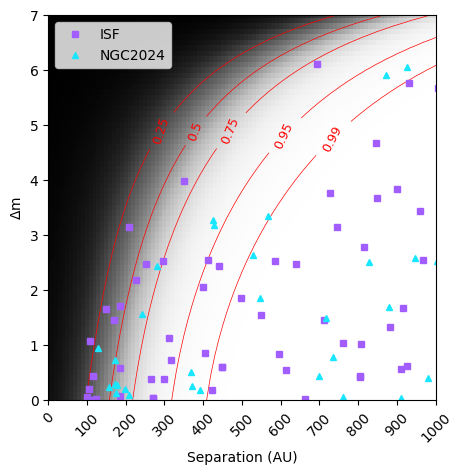

In [57]:
dms = np.arange(0, 7.01, 1/10)
seps = np.arange(0, 2001., 100/10)
dm_mtx, sep_mtx = np.indices((len(dms), len(seps)))
#sep_mtx = np.tile(np.arange(0, 2000.1, 0.1), )
dm_mtx, sep_mtx = (np.flip(dm_mtx,0))/10, 100*(sep_mtx+5)/10
frac_mtx = np.zeros(dm_mtx.shape)
n_dm = len(dms)
for i in range(len(mu)):
    frac_mtx[i, :] =  norm_logistic_reg(seps, mu[i], sig[i])
    
cmap = plt.cm.cool
category_colors = plt.colormaps['cool'](np.linspace(0.10, 0.85, 8))

fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(frac_mtx, origin='lower', cmap='Greys_r', aspect="auto")


c25 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.25], colors='r', alpha=0.99, linewidths=0.5)
c50 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.50], colors='r', alpha=0.99, linewidths=0.5)
c75 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.75], colors='r', alpha=0.99, linewidths=0.5)
c95 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.95], colors='r', alpha=0.99, linewidths=0.5)
c99 = ax.contour(np.arange(0, len(seps), 1), np.arange(0, n_dm, 1), frac_mtx[:,:], 
           [0.99], colors='r', alpha=0.99, linewidths=0.5)

xt = ax.get_xticks()
#ax.set_xticks(xt[1::], np.round(xt[1::]*100/10).astype(int))
ax.set_xticks(np.arange(0, 201, 10), np.arange(0, 2001, 100), rotation=45)
yt = ax.get_yticks()
ax.set_yticks(yt[1:-1], np.round((yt[1:-1])/10).astype(int))


manual_locations = [(20, 50)]
plt.clabel(c25, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(30, 50)]
plt.clabel(c50, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(40, 50)]
plt.clabel(c75, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(50, 50)]
plt.clabel(c95, fontsize=9, inline=1, manual=manual_locations)
manual_locations = [(60, 50)]
plt.clabel(c99, fontsize=9, inline=1, manual=manual_locations)

ax.set_xlabel('Separation (AU)')
ax.set_ylabel('$\Delta$m')


ra_cat, dec_cat, m_cat, i_yso = ra_f2, dec_f2, m_f2, i_yso
N_total = len(i_yso)
N_cand, N_cont = 0, 0
r1_comp = 100
r2_comp = 2000
r1_cont = 2000
r2_cont = 5000

#Making a catalog object using all sources
c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
              distance=400.*u.pc, frame='fk5')

ra_yso  = ra_cat[i_yso]
dec_yso = dec_cat[i_yso]
m_yso   = m_cat[i_yso]

i_tested = np.array([])
N_cand   = np.array([])

d_comp = np.array([])
dm_comp = np.array([])
r_comp = np.array([])
dc_comp = np.array([])
mag_prim = np.array([])

for i in range(N_total):
    #Making a catalog object using YSO
    c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
    sep_     = c2.separation(c1).arcsec*400.
    i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp)&(m_cat>10.5))
    n_obj    = len(i_obj_)

    if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.)&(m_yso[i]>12.):
        ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
        dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
        m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array

        i_prim, = np.where(m_sys==np.min(m_sys))
        i_comp, = np.where(m_sys!=np.min(m_sys))
        N_cand  = N_cand + len(i_comp)
        ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
        ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]
        m_prim = m_sys[i_prim]
        c_comp = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')

        c_prim = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
        sep_comp = c_comp.separation(c_prim).arcsec*400.
        #ax.plot(sep_comp, m_sys[i_comp]-m_prim, '.r')
        d_comp = np.append(d_comp, sep_comp)
        dm_comp = np.append(dm_comp, np.abs((m_sys[i_comp]-m_prim)))
        r_comp, dc_comp = np.append(r_comp, ra_comp), np.append(dc_comp, dec_comp)
        mag_prim = np.append(mag_prim, np.ones(ra_comp.shape)*m_prim[0])
ax.plot(d_comp/10, dm_comp*10, 's', c=category_colors[5], ms=4, label='ISF')
ax.plot(sep_flame/10, dm_flame*10, '^', c=category_colors[0], ms=4, label='NGC2024')

ax.set_yticks(np.arange(0, 71, 10), np.arange(0, 8, 1))
ax.set_ylim(0, 70)

ax.set_xlim(0, 100)
ax.legend()

In [70]:
def CF(ra_cat, dec_cat, m_cat, i_yso):
    N_total = len(i_yso) #Total number of YSOs
    N_cand, N_cont, N_comp = 0, 0, 0
    
    r1_comp = 100
    r2_comp = 1000
    r1_cont = 2000
    r2_cont = 5000
    
    bw = 100
    bins = (np.zeros((len(i_yso), len(np.arange(1, 5000/bw+1, 1)))))
    bin_count = np.arange(1, 5000/bw+1, 1, dtype=int)

    def r_times_logistic_reg(x, m, s):
        w = x*1/(1+np.exp(-((x-m)/s)))
        return w
    
    
    #Making a catalog object using all sources
    c2 = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree, 
                  distance=400.*u.pc, frame='fk5')
   
    ra_yso  = ra_cat[i_yso]
    dec_yso = dec_cat[i_yso]
    m_yso   = m_cat[i_yso]
    
    i_tested = np.array([])

    R     = np.array([])
    R_unc = np.array([])
    N_cont_init = np.array([])
    N_cont_corr = np.array([])
    N_cont_prior_corr = np.array([])
    N_cont  = 0
    d_mag   = np.array([])
    dist    = np.array([])
    cont_m  = np.array([])
    #fig, ax = plt.subplots()
    
    for i in range(N_total):
        
        
        #Making a catalog object using the ith YSO
        c1       = SkyCoord(ra=ra_yso[i]*u.degree, dec=dec_yso[i]*u.degree, distance=400.*u.pc, frame='fk5')
        sep_     = c2.separation(c1).arcsec*400.
        i_obj_,  = np.where((sep_>=r1_comp)&(sep_<=r2_comp))#&(m_cat>10.5))
        n_obj    = len(i_obj_)
        
        for i_bin in bin_count:
            i_obj_bin,  = np.where((sep_>=i_bin*bw)&(sep_<=(i_bin*bw+bw)))
            bins[i,i_bin-1] = np.sum(i_obj_bin)
                                 
        if (n_obj>0)&(~np.isin(i_yso[i], i_tested))&(m_yso[i]<19.):
            ra_sys  = np.append(ra_yso[i], ra_cat[i_obj_])
            dec_sys = np.append(dec_yso[i], dec_cat[i_obj_])
            m_sys   = np.append(m_yso[i], m_cat[i_obj_]) #adding primary and the companions to 1 array
            if len(i_tested)==0:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=False)
            else:
                write_regf(ra_sys, dec_sys, 'companions.reg', 'red', [], r=30, update=True)
            
            
            i_prim, = np.where(m_sys==np.min(m_sys))
            i_comp, = np.where(m_sys!=np.min(m_sys))
            
            m_prim = m_sys[i_prim]
            m_comp = m_sys[i_comp]
            
            if np.abs(m_comp - m_prim).any() <= 7.0:
                i_comp = i_comp[np.abs(m_comp - m_prim)<=7.0]
                m_comp = m_sys[i_comp]

                ra_comp, dec_comp = ra_sys[i_comp], dec_sys[i_comp]
                ra_prim, dec_prim = ra_sys[i_prim], dec_sys[i_prim]

                c_comp   = SkyCoord(ra=ra_comp*u.degree, dec=dec_comp*u.degree, distance=400.*u.pc, frame='fk5')
                c_prim   = SkyCoord(ra=ra_prim*u.degree, dec=dec_prim*u.degree, distance=400.*u.pc, frame='fk5')
                sep_comp = c_comp.separation(c_prim).arcsec*400.

                #making a new cat obj with the dimmest objects in the system
                #n_obj is recalculated using the "new" primary.
                sep      = c2.separation(c_prim).arcsec*400.
                i_obj_,  = np.where((sep>=r1_comp)&(sep<=r2_comp))#&(m_cat>10.5))
                n_obj    = len(i_obj_)
                N_cand   = N_cand + n_obj
                i_cont,  = np.where((sep>=r1_cont)&(sep<=r2_cont))
                
        else:
            m_prim   = m_yso[i]
            i_cont,  = np.where((sep_>=r1_cont)&(sep_<=r2_cont))
        
        N_cont_init = np.append(N_cont_init, len(i_cont))
        n_cont      = 0
        #if len(i_cont)>0: #N_contaminants is calculated around all YSOs in the region.
        for j in range(len(i_cont)):
            delta_m = m_cat[i_cont[j]]-m_prim
            cont_m = np.append(cont_m, m_cat[i_cont[j]])
            dm_int  = int(np.abs(10*np.round(delta_m, 1)))
            if dm_int>70: #80: delta_mag=8
                mu_, sig_ = 0, 0
                R_ = 0
            else:
                mu_  = mu[dm_int]
                sig_ = sig[dm_int]
                I  = quad(r_times_logistic_reg, r1_comp, r2_comp, args=(mu_, sig_))
                R_ = 2*np.pi * I[0] / (np.pi*(r2_cont**2 - r1_cont**2))
                R  = np.append(R, R_)
                d_mag=np.append(d_mag,dm_int)
                R_unc   = np.append(R_unc, I[1])
                dist = np.append(dist, sep_[i_cont[j]])
            n_cont  = n_cont + R_


        N_cont_corr = np.append(N_cont_corr, n_cont)
        N_cont_prior_corr = np.append(N_cont_prior_corr, 
                                      len(i_cont)*
                                      (r2_comp**2-r1_comp**2)/(r2_cont**2-r1_cont**2))
        #N_cont = np.append(N_cont, n_cont)


        
            
        i_tested = np.append(i_tested, i_yso[i])
        i_tested = np.append(i_tested, i_obj_)
        
        
        
    N_comp   = N_cand - np.sum(N_cont_corr)
        

    category_colors = plt.colormaps['plasma'](np.linspace(0.05, 0.85, 5))
    #for i in range(len(dist)):
    #    ax.plot(dist[i], d_mag[i], '.', color=category_colors[int(100*np.round(R[i], 3))])           
    #ax.plot(R, '.r')
    print('N_cand: '+str(N_cand)+'/'+str(N_total))
    print('N_cont within 200-5000 (before correction): ', np.sum(N_cont_prior_corr))
    print('N_cont within 200-5000: ', np.sum(N_cont_corr))
    print('N_contaminants: ', np.sum(N_cont_init))
    print('N_comp: ', N_comp)
    print('CF:', N_comp/N_total)
    return d_mag, N_cont_corr, dist, cont_m, bins, bin_count

In [71]:
dmag, N_cont_arr, dist, cmag, sig_bins, bin_count,  = CF(ra_f2, dec_f2, m_f2, i_yso)

N_cand: 92/671
N_cont within 200-5000 (before correction):  40.30714285714286
N_cont within 200-5000:  32.34704739197907
N_contaminants:  855.0
N_comp:  59.65295260802093
CF 0.08890156871538142


In [72]:
bw=100
bin_radii = bin_count*bw
bin_areas = np.pi*((bin_radii)**2-(bin_radii-bw)**2)
bin_mean = np.mean(sig_bins, axis=0)/bin_areas

### P($<\Delta$r) = $\frac{r^2 - r^2_{1}}{r^2_{2} - r^2_{1}}$

$r_1$ = 100, 
$r_2$ = 1000

$r = \sqrt{N(r_2^2 - r_1^2) + r_1^2}$

In [12]:
def P_r(r1, r2, dr):
    r = np.arange(r1, r2, dr)
    return (r**2 - r1**2)/(r2**2 - r1**2)

Text(0, 0.5, 'f ($\\Delta$r)')

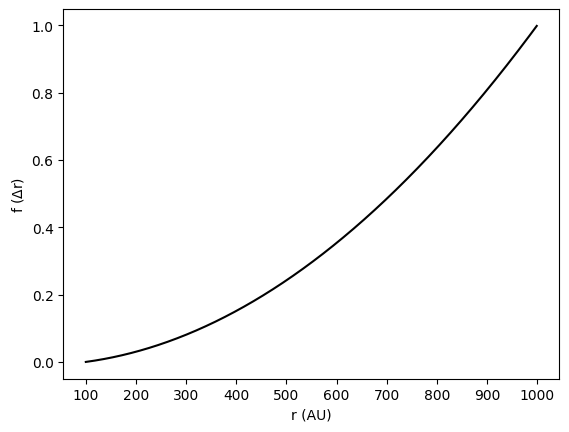

In [181]:
fig, ax = plt.subplots()
ax.plot(np.arange(100, 1000, 1), P_r(100, 1000, 1), 'k-')
ax.set_xticks(np.arange(100, 1100, 100))
ax.set_xlabel('r (AU)')
ax.set_ylabel('f ($\Delta$r)')

### P($<\Delta$m)

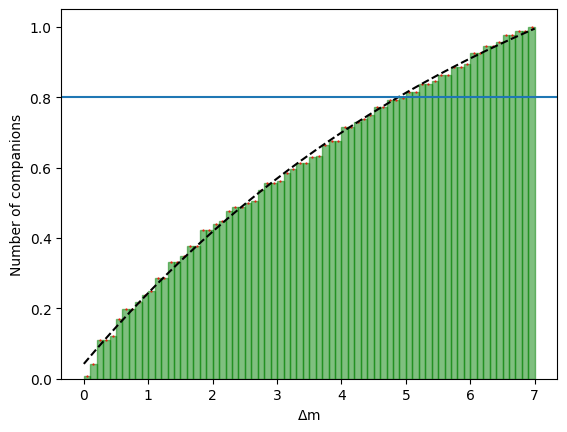

In [321]:
plt.subplot()
bw=100
n, bins, patches = plt.hist(dmag/10, bins=np.arange(0, 7.051, 0.1),
                            density = True, cumulative=True,
                           color='green', alpha=0.5, edgecolor='g')
#plt.plot(bins[0:-1]+0.05, n, '.r')
plt.xlabel('$\Delta$m')
plt.ylabel('Number of companions')

#interpolated = pm.Interpolated.dist(np.arange(0, 8, 1), )
def parabola(x, a, b, c):
    return a - b*np.exp(-c*(x))
plt.plot(bins[0:-1]+0.05, n, '.r', ms=1)
popt, pcov = curve_fit(parabola, bins[0:-1]+0.05, n, p0=[1, 100, 1])
#mu = popt

x = np.arange(0, 7.00001, 0.01)
plt.plot(x, parabola(x, *popt), 'k--', ms=1)
plt.axhline(0.8)

In [301]:
popt

array([1.53778978, 1.49562009, 0.14470388])

### P($<\Delta$m) = A - B $\cdot e^{-C \cdot x}$ (cumulative),

where A = 1.60483705, B = 1.51651561, and C = 0.13385079

### $x = -\frac{log[(A - N)/B]}{c}$

## $P(\Sigma_{los} | N_{cont})= \frac{(\Sigma_{los}\Omega_{cont})^{N_{cont}}}{N_{cont}!}e^{-\Sigma_{los}\Omega_{cont}}$

### Poisson distribution = $\frac{\mu^{x}}{x!}\cdot e^{-\mu}$

$N_{cont} \sim Poisson()$

$P(\Sigma_{los} | N_{cont}) \sim Gamma()$

In [128]:
def P_sig(sig, O_cont, N_cont):
    return pm.(sig*O_cont)**N_cont * np.exp(-sig*O_cont) / scipy.special.factorial(N_cont)

In [86]:
N_cand = 92
r1, r2 = 100, 1000
r3, r4 = 2000, 5000
O_cont = np.pi*(r4**2 - r3**2)
N_cont_ = N_cont_arr
sig_los = N_cont_arr/O_cont * np.pi * (r2**2 - r1**2)

*Note: missng constant = (N_cont+1)/O_cont*

In [182]:
with pm.Model() as P_siglos:
    y_obs = pm.Gamma('sig', alpha=855+1, beta=O_cont)
    sig_trace = pm.sample(draws=1000, chains=4)
    sig_forecast = pm.sample_posterior_predictive(sig_trace, var_names=['sig'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Sampling: [sig]


In [188]:
sig_trace

Inference data with groups:
	> posterior
	> sample_stats

## 1000 Draws

### $\Delta m = -\frac{ln[(A - N)/B]}{c}$
$r = N(r_2^2 - r_1^2) + r_1^2$

In [376]:
def solv_delm(n_):
    a, b, c = 1.53778978, 1.49562009, 0.14470388
    return -1 * np.log((a-n_)/b) / c

def solv_r(n_):
    r1, r2 = 100, 1000
    return np.sqrt(n_ * (r2**2 - r1**2) + r1**2)

Text(0, 0.5, 'P($\\Sigma$)')

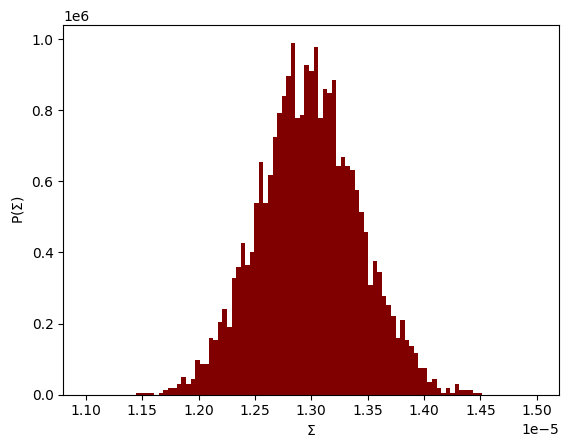

In [206]:
#with 1000 draws hist
fig, ax = plt.subplots()
ax.hist(sig_forecast.posterior_predictive['sig'].data.flatten()
        , density=True, bins=np.linspace(1.10e-5, 1.5e-5, 100), color='maroon')
ax.set_xlabel('$\Sigma$')
ax.set_ylabel('P($\Sigma$)')

Text(0, 0.5, 'P($\\Sigma$)')

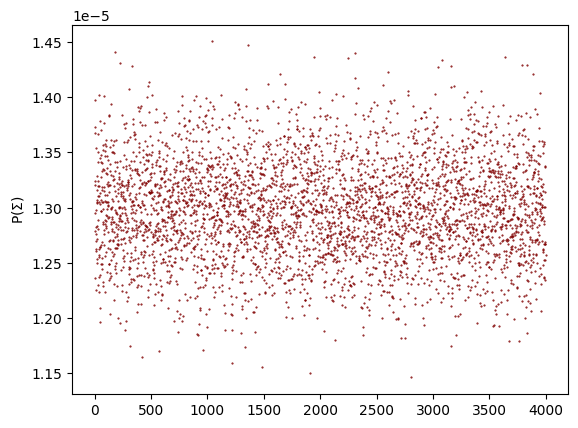

In [207]:
plt.subplots()
plt.plot(sig_forecast.posterior_predictive['sig'].data.flatten(), '.', ms=1, 
         color='maroon')
plt.ylabel('P($\Sigma$)')

In [212]:

O_comp = np.pi*(r2**2-r1**1)
r1, r2

(100, 1000)

In [240]:
for i in range(10):
    #random.seed()
    print(np.random.randint(1000000))

246216
501488
217474
386269
208693
994407
465078
909263
468670
531430


In [213]:
sig_       = sig_forecast.posterior_predictive['sig'].data.flatten()
chosen_sig = random.choice(sig_)


SEED = np.random.randint(1000000)

SAMPLE_KWARGS = {"chains": 4, "tune": 1000, 
                 "random_seed": [SEED, SEED + 1, SEED + 2, SEED + 3]}

with pm.Model() as P_Ncont:
    y_obs = pm.Poisson('Ncont', mu=chosen_sig*O_comp)
    Ncont_trace = pm.sample(draws=1000, chains=4, seed=SAMPLE_KWARGS)
    Ncont_forecast = pm.sample_posterior_predictive(Ncont_trace, var_names=['Ncont'])
    
chosen_N = random.choice(N_)

n_bin, bins, a = plt.hist(N_, cumulative=True, density=True, 
                      bins=np.arange(24.5, 65.5, 1))


Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [Ncont]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [Ncont]


In [ ]:
plt.xlabel('N_cont drawn from the distribution')
plt.ylabel('density of N_cont')

Text(0, 0.5, 'density of N_cont')

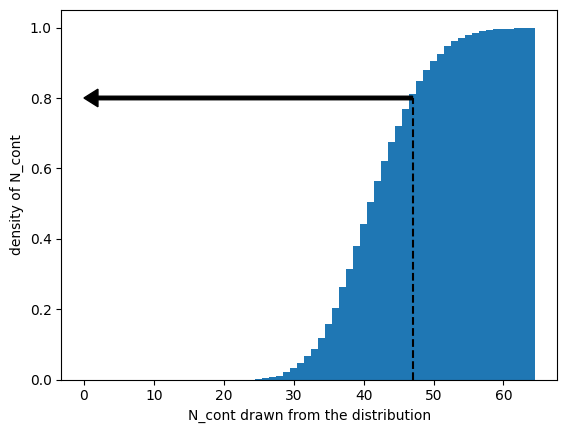

In [373]:
N_ = Ncont_forecast.posterior_predictive['Ncont'].data.flatten()
plt.subplots()
n_bin, bins, a = plt.hist(N_, cumulative=True, density=True, 
                      bins=np.arange(24.5, 65.5, 1))
plt.arrow(47, 0.8, -47, 0, width=0.01, color='k', length_includes_head = True,
         head_width=0.05, head_length=2)
plt.vlines(47, 0, 0.8, color='k', ls='--')
plt.xlabel('N_cont drawn from the distribution')
plt.ylabel('density of N_cont')

In [402]:
solved_delm = solv_delm(n_)
solved_r    = solv_r(n_)
i_dm, i_r = int(np.round(solved_delm, 1)*10), int(np.round(solved_r/10))
frac_mtx[i_dm,i_r]

In [320]:
a, b, c = 1.53778978, 1.49562009, 0.14470388
n_ = n[np.where(bins==chosen_N-0.5)][0]
-1*np.log((a-n_)/b)/c

4.97730794152777

In [408]:
frac_mtx[i_dm,i_r]

0.9999997962190745

In [393]:
np.round(solved_delm, 1)

5.0

In [404]:
i_dm, i_r

(50, 90)